In [76]:
# dataset found here:
# pesticide: https://www.kaggle.com/usgs/pesticide-use/version/1
# food growth: https://www.kaggle.com/dorbicycle/world-foodfeed-production

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import requests
from bs4 import BeautifulSoup

In [106]:
# high and low estimates of pesticide use per county
df_2014 = pd.read_csv('data/pesticide_use/2014.csv')
df_2015 = pd.read_csv('data/pesticide_use/2015.csv')
df_dict = pd.read_csv('data/pesticide_use/dictionary.csv')

df_pestuse14 = pd.merge(df_dict, df_2014, how='right')
df_pestuse14.rename(columns={'LOW_ESTIMATE':'14_LOW_ESTIMATE','HIGH_ESTIMATE':'14_HIGH_ESTIMATE'}, inplace=True)
df_pestuse14.drop(['YEAR'], axis=1,inplace=True)

df_pestuse15 = pd.merge(df_dict, df_2015, how='right')
df_pestuse15.rename(columns={'LOW_ESTIMATE':'15_LOW_ESTIMATE','HIGH_ESTIMATE':'15_HIGH_ESTIMATE'}, inplace=True)
df_pestuse15.drop(['YEAR'], axis=1,inplace=True)

df_pestuse = pd.merge(df_pestuse14, df_pestuse15, how='left')
df_pestuse.drop(['STATE_CODE','COUNTY_CODE'], axis=1,inplace=True)
df_pestuse.index += 1

df_pestuse = df_pestuse.fillna(0)

In [59]:
df_pestuse.head()

,COUNTY,STATE,COMPOUND,14_LOW_ESTIMATE,14_HIGH_ESTIMATE,15_LOW_ESTIMATE,15_HIGH_ESTIMATE
1,Autauga County,AL,"2,4-D",1698.6,1885.5,3243.5,3363.2
2,Autauga County,AL,"2,4-DB",82.8,264.3,40.6,40.6
3,Autauga County,AL,Abamectin,8.6,8.9,0.0,2.5
4,Autauga County,AL,Acephate,707.9,707.9,547.7,662.1
5,Autauga County,AL,Acetochlor,649.5,859.5,31.1,1387.7


In [114]:
# get average annual rainfall from below site
r = requests.get('https://www.currentresults.com/Weather/US/average-annual-state-precipitation.php')
soup = BeautifulSoup(r.text, 'lxml')

df1 = pd.read_html(str(soup.find_all('table')[0]))[0]
df2 = pd.read_html(str(soup.find_all('table')[1]))[0]
df3 = pd.read_html(str(soup.find_all('table')[2]))[0]

df1_indexed = df1.set_index('State')
df2_indexed = df2.set_index('State')
df3_indexed = df3.set_index('State')

df_rain = pd.concat([df1_indexed, df2_indexed, df3_indexed])
df_rain = df_rain.sort_values('State', ascending=True)
df_rain = df_rain.drop(['Rank'], axis=1)
df_rain = df_rain.reset_index()
df_rain.head()

,State,Inches,Milli­metres
0,Alabama,58.3,1480
1,Alaska,22.5,572
2,Arizona,13.6,345
3,Arkansas,50.6,1284
4,California,22.2,563


In [115]:
r = requests.get('https://www.omnisci.com/docs/latest/3_apdx_states.html')
soup = BeautifulSoup(r.text, 'lxml')

df_stateabr = pd.read_html(str(soup.find_all('table')))
df_state = df_stateabr[0]
df_state.head()

,State,Abbreviation
0,Alabama,AL
1,Alaska,AK
2,Arizona,AZ
3,Arkansas,AR
4,California,CA


In [125]:
# use lookup to get appropriate state abbreviations for average rainfall, then merge with pesticide table
df_rainfall = pd.merge(df_rain, df_state, how='left')
df_rainfall.drop(['State','Milli­metres'], axis=1, inplace=True) # note odd symbol in millimetres
df_rainfall.rename(columns={'Abbreviation':'STATE', 'Inches':'RAIN_INCHES'}, inplace=True)
df_rainfall.head()

,RAIN_INCHES,STATE
0,58.3,AL
1,22.5,AK
2,13.6,AZ
3,50.6,AR
4,22.2,CA


In [127]:
pestuse_withrain = pd.merge(df_pestuse, df_rainfall, how='left')
pestuse_withrain.head()

,COUNTY,STATE,COMPOUND,14_LOW_ESTIMATE,14_HIGH_ESTIMATE,15_LOW_ESTIMATE,15_HIGH_ESTIMATE,RAIN_INCHES
0,Autauga County,AL,"2,4-D",1698.6,1885.5,3243.5,3363.2,58.3
1,Autauga County,AL,"2,4-DB",82.8,264.3,40.6,40.6,58.3
2,Autauga County,AL,Abamectin,8.6,8.9,0.0,2.5,58.3
3,Autauga County,AL,Acephate,707.9,707.9,547.7,662.1,58.3
4,Autauga County,AL,Acetochlor,649.5,859.5,31.1,1387.7,58.3


In [214]:
# plot mississippi
ms_pestuse = pestuse_withrain[pestuse_withrain['STATE'] == 'MS']
ms_pestuse.reset_index(inplace=True)
ms_pestuse.drop(['index'], axis=1,inplace=True)

# just bolivar county
ms_bolivar_pestuse = ms_pestuse[ms_pestuse['COUNTY'] == 'Bolivar County']
ms_bolivar_pestuse.head()

,COUNTY,STATE,COMPOUND,14_LOW_ESTIMATE,14_HIGH_ESTIMATE,15_LOW_ESTIMATE,15_HIGH_ESTIMATE,RAIN_INCHES
505,Bolivar County,MS,"2,4-D",13193.0,14827.0,57987.2,57987.2,59.0
506,Bolivar County,MS,Abamectin,5.4,31.5,0.0,2.9,59.0
507,Bolivar County,MS,Acephate,4855.7,8472.2,2990.7,2990.7,59.0
508,Bolivar County,MS,Acetamiprid,0.0,11.0,0.0,2.7,59.0
509,Bolivar County,MS,Acetochlor,4781.0,35835.1,10820.9,12275.3,59.0


In [215]:
ms_bolivar_pestuse.set_index(['COMPOUND'], inplace=True)
#ms_bolivar_15sorted.head()

In [216]:
ms_bolivar_sorted = ms_bolivar_pestuse.sort_values(by=['15_HIGH_ESTIMATE'], ascending=False)
# don't need rain for one county - all the same
ms_bolivar_sorted.drop(['RAIN_INCHES'], axis=1, inplace=True)

In [217]:
ms_bolivar_sorted.head()

,COUNTY,STATE,14_LOW_ESTIMATE,14_HIGH_ESTIMATE,15_LOW_ESTIMATE,15_HIGH_ESTIMATE
COMPOUND,,,,,,
Metolachlor-S,Bolivar County,MS,54619.5,54619.5,194094.7,194094.7
Glyphosate,Bolivar County,MS,219914.2,219921.7,171575.0,171758.7
"2,4-D",Bolivar County,MS,13193.0,14827.0,57987.2,57987.2
Paraquat,Bolivar County,MS,16069.6,16069.6,52190.2,55351.5
Propanil,Bolivar County,MS,0.0,23768.4,27635.3,27635.3


In [219]:
ms_bolivar_sorted['15_AVG'] = ms_bolivar_sorted[['15_LOW_ESTIMATE', '15_HIGH_ESTIMATE']].mean(axis=1)
ms_bolivar_sorted['14_AVG'] = ms_bolivar_sorted[['14_LOW_ESTIMATE', '14_HIGH_ESTIMATE']].mean(axis=1)
ms_bolivar_final = ms_bolivar_sorted.drop(['14_LOW_ESTIMATE', '15_LOW_ESTIMATE', '15_HIGH_ESTIMATE', '14_HIGH_ESTIMATE'], axis=1)
ms_bolivar_final.head()

,COUNTY,STATE,15_AVG,14_AVG
COMPOUND,,,,
Metolachlor-S,Bolivar County,MS,194094.70,54619.50
Glyphosate,Bolivar County,MS,171666.85,219917.95
"2,4-D",Bolivar County,MS,57987.20,14010.00
Paraquat,Bolivar County,MS,53770.85,16069.60
Propanil,Bolivar County,MS,27635.30,11884.20


In [223]:
ms_bolivar_final = ms_bolivar_final.sort_values(by=['15_AVG'], ascending=False)
ms_bolivar_final.head()

,COUNTY,STATE,15_AVG,14_AVG
COMPOUND,,,,
Metolachlor-S,Bolivar County,MS,194094.70,54619.50
Glyphosate,Bolivar County,MS,171666.85,219917.95
"2,4-D",Bolivar County,MS,57987.20,14010.00
Paraquat,Bolivar County,MS,53770.85,16069.60
Propanil,Bolivar County,MS,27635.30,11884.20


array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000270CC6A6390>,
      dtype=object)

<Figure size 432x288 with 0 Axes>

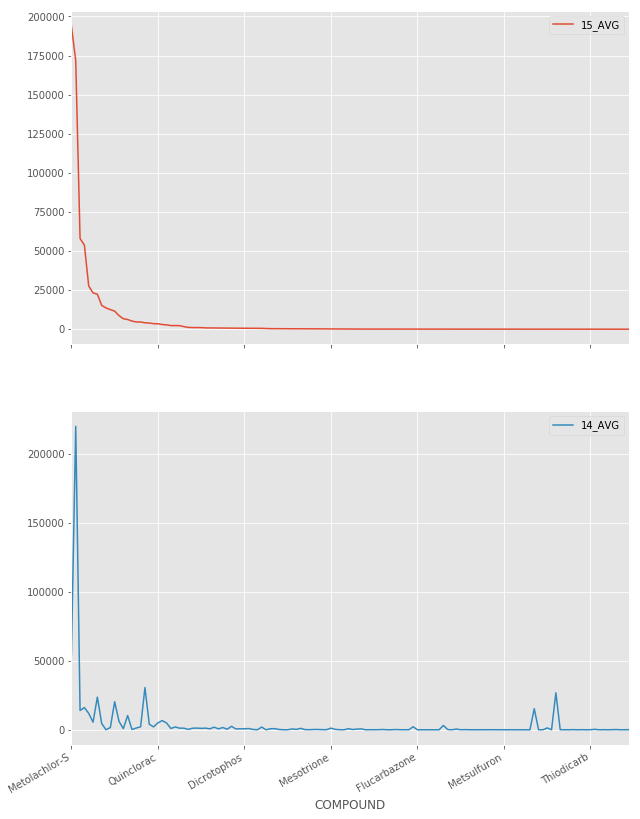

In [222]:
#plot mississippi
fig = plt.figure()
plt.style.use('ggplot')
ms_bolivar_final.plot(subplots=True, figsize=(10,15))